# Outbreak size in the SIR model (Kermack-McKendrick relation)

Continuing our investigation of the Susceptible-Infected-Recovered model, we will add demographics and investigate the behavior of the model in and around the endemic equilibrium.  The first 

$$
\dot{S} = -\frac{\beta*S*I}{N} + \mu N - \mu S\\

\dot{I} = \frac{\beta*S*I}{N} - \gamma I - \mu I\\

\dot{R} = \gamma I - \mu R
$$

Analysis of this system can be found in other sources (ref. Keeling/Rohani).  Setting the derivatives to zero and doing a bit of algebra gets you to the endemic equilbrium

$$
(S^*, \: I^*, \: R^*) = (\frac{1}{R_0}, \:\: \frac{\mu (R_0-1)}{\beta}, \: \: 1-\frac{1}{R_0} - \frac{\mu (R_0-1)}{\beta}) \\

\text{where} \:\: R_0 = \frac{\beta}{\gamma + \mu}
$$

An individual susceptible's mean time to infection will then be the inverse of the total force of infection, $\beta I^*$.  
$$
\tau_{S \rightarrow I} = \frac{1}{\mu (R_0 -1)}
$$

The equation above is often also described as the average age at infection.  However, it is key to remember that the measured age at infection will be censored by non-disease deaths occurring at a rate $\mu$.  You can work through the impact of this, but in the simple case of constant mortality, it turns out to exactly balance out the $-1$ in the above equation, and so our *observed* average age at infection will be $\frac{1}{\mu R_0}$.  Since the hazard is constant at equilibrium, this implies an exponential distribution:

$$P(a | S->I) \sim \mu R_0 e^{-\mu R_0 a}$$

Alternatively, we can correct for the influence of mortality by observing the fraction of children who are susceptible at age A, which necessarily conditions on survival to age A.  This will look like the cumulative distribution of an exponential distributed according to the mean time to infection above:

$$P(R | a) \sim 1 - e^(-a \mu (R_0-1))$$

### Contruct the model
In the first few cells, we do all the necessary imports.  Because we are now measuring an equilibrium property of this system, we will have to burn in, with repeated infection importations to ensure that we establish an endemic equilibrium.  We also need to model a large enough population to sustain the infection (see Critical Community Size notebook).  The primary determinant of the critical community size is the duration of infection, so keeping this relatively long (2 months) prevents us from needing huge agent populations.  So, we construct a single-patch LASER model with fice components: `Births_ConstantPop`, `Susceptibility`, `Transmission`, `Infection`, and `Infect_Random_Agents`, a function that implements repeated importation for a fixed period of time. 

### Sanity check
The first test, as always, ensures that certain basic constraints are being obeyed by the model.  As it stands, I am not actually explicitly tracking the recovered population, but I can check that $S_t = N_t - \sum{\Delta_I}$.  

### Scientific test
The scientific test will sample a set of $(\mu, R_0)$ pairs and confirm that both the age at infection and the fraction of susceptibles at a given age are well-described by exponential distributions and that the associated rate constant is as expected.   



In [16]:
import numpy as np
import pandas as pd
from laser_core.propertyset import PropertySet
import matplotlib.pyplot as plt
import itertools

from scipy.optimize import fsolve
import scipy.fftpack as fftpack

from laser_generic import Model
from laser_generic import Infection
from laser_generic import Susceptibility
from laser_generic import Transmission
from laser_generic import Births_ConstantPop
from laser_generic.importation import Infect_Random_Agents
from scipy.stats import expon
from scipy.stats import kstest
from laser_generic.utils import set_initial_susceptibility_randomly
from laser_generic.utils import seed_infections_randomly

f"{np.__version__=}"

"np.__version__='1.26.4'"

In [17]:
scenario = pd.DataFrame(data=[["homenode", 1e5, "47°36′35″N 122°19′59″W"]], columns=["name", "population", "location"])
parameters = PropertySet({"seed": 4, 
                          "nticks": 18250, 
                          "verbose": True, 
                          "beta": 0.1, 
                          "inf_mean": 60, 
                          "cbr": 90, 
                          "importation_period": 180, 
                          "importation_count": 3})

2025-01-10 23:41:27.970681: Creating the generic model…
Initializing the generic model with 1 patches…
2025-01-10 23:41:27.974788: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:07<00:00, 2501.85it/s]


Completed the generic model at 2025-01-10 23:41:35.271150…
Susceptibility_census:       381,342 µs
Transmission_census  :       502,566 µs
Infection_census     :       921,432 µs
Model                :        51,902 µs
Infect_Random_Agents :        44,660 µs
Births_ConstantPop   :     3,591,126 µs
Susceptibility       :        23,516 µs
Transmission         :     6,989,016 µs
Infection            :     1,717,302 µs
Total:                    14,222,862 microseconds


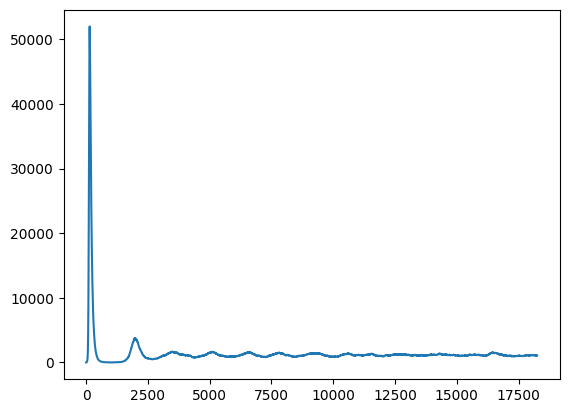

In [18]:
model = Model(scenario, parameters)
model.components = [
    Infect_Random_Agents,
    Births_ConstantPop,
    Susceptibility,
    Transmission,
    Infection,
]

seed_infections_randomly(model, ninfections=1)
model.run()
plt.plot(model.patches.cases)

### Sanity checks
As always, check that we haven't broken anything - S+I+R = N at all times.

I continue to have these alignment issues between S, I, R.  Something to return to.  The more complex we make the model, the more this sort of thing will pop up.  I'm going to suggest an addition to "model.py" that puts all of these state census functions right up front.  

In [19]:
cases = np.squeeze(model.patches.cases)
susc = np.squeeze(model.patches.susceptibility)
rec = np.squeeze(model.patches.recovered)
inc = np.squeeze(model.patches.incidence)
births = np.squeeze(model.patches.births)
pops = np.squeeze(model.patches.populations)[:-1]

print('S+I+R = N:  '+str(np.isclose(cases+susc+rec, pops).all()))


S+I+R = N:  True


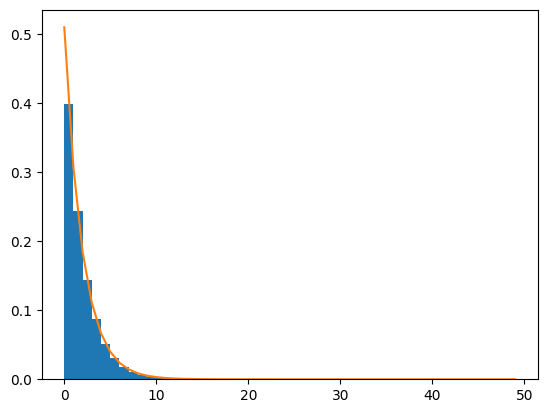

In [26]:
cut = model.population.doi > 10000
plt.hist((model.population.doi[cut] - model.population.dob[cut])/365, bins=np.arange(50), density=True)
mu = ((1+model.params.cbr/1000)**(1/365)-1)
R0 = model.params.beta / (1/model.params.inf_mean + mu)

A = 1/((R0)*mu) / 365
a = np.arange(50)
plt.plot(a, 1/A * np.exp(-a/A))

In [27]:
cut = model.population.doi > 1
np.mean(model.params.nticks - model.population.dob[~cut])/365

2.0731607073863962

In [28]:
1/(R0)*1/mu / 365

1.9611573796171695

In [29]:
from scipy.stats import expon
from scipy.stats import kstest
cut = model.population.doi > 1000 
cut = cut & ((model.population.doi - model.population.dob)>0)
data = (model.population.doi[cut] - model.population.dob[cut])
params = expon.fit(data)
params
kstest(data, expon.cdf, params)
params

(1.0, 713.0572748497342)

(0.0, 2500.0)

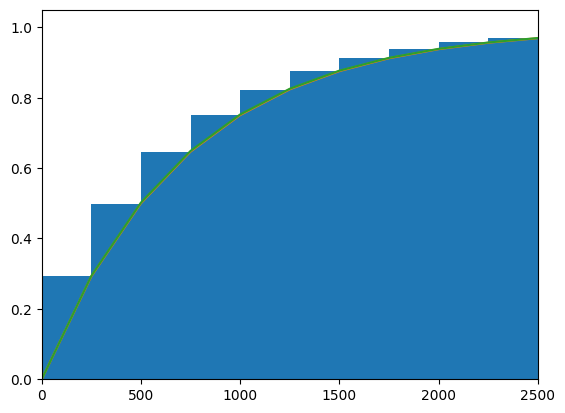

In [11]:
bins = np.arange(0, 50*365, 250)
plt.hist(data, bins=bins, cumulative=True, density=True)
plt.plot(bins, expon.cdf(bins, *params))
plt.plot(bins, expon.cdf(bins, params[0], A*365))
plt.xlim(0, 2500)

In [10]:
params[1]/365

2.473062358336015

2.3600763059823255

array([2.63394669])

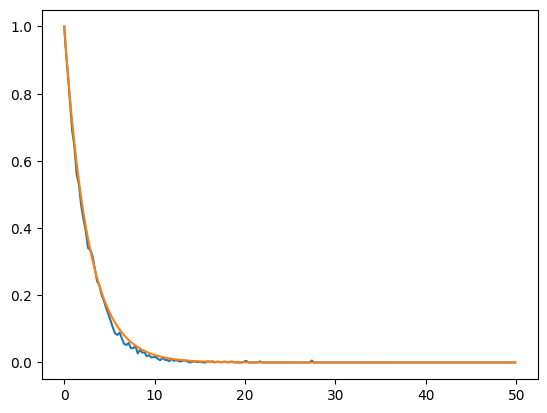

In [12]:
from scipy.optimize import curve_fit
cut = model.population.susceptibility==1
bins = np.linspace(0, 50, 201)
age_years = (np.max(model.population.dob)-model.population.dob)/365
n1 = np.histogram(age_years, bins=bins)[0]
n2 = np.histogram(age_years[cut], bins=bins)[0]
n1[n1==0]=1
y1 = n2/n1
y2 = 1-np.cumsum(n2)/np.sum(n2)
def Scurve(x, A):
    return np.exp(-x/A)

popt, pcov = curve_fit(Scurve, bins[:-1]+np.mean(np.diff(bins)), y1, p0=2.5)
plt.plot([0, *bins[:-1]+np.mean(np.diff(bins))/2], [1, *y1])
#plt.plot([0, *bins[:-1]+np.mean(np.diff(bins))], [1, *(1-np.cumsum(n2)/np.sum(n2))])
plt.plot([0, *bins[:-1]+np.mean(np.diff(bins))/2], [1, *(Scurve(bins[:-1]+np.mean(np.diff(bins))/2, *popt))])
#plt.hist(data/365, bins, density=True, alpha=0.5)
#plt.xlim([0, 10])
popt


In [61]:
#Test that population age distribution is correct
print(expon.fit(age_years))
print(1/(model.params.cbr/1000))


(0.0, 11.11696324109589)
11.11111111111111


In [15]:
print(expon.fit(age_years[cut]))

(0.0, 2.0301213324953635)


11.11111111111111

In [ ]:
#OK, testing this is a bit more of a pain, since we are running out to some equilibrium-ish condition.
#With a large initial outbreak from full susceptibility, this could be a long time to equilibrate.
#Partial solution - start us near R-eff=1, but not with the age distribution that we expect, and 
# let it equilibrate towards that age distribution over a couple of generations.  Still not ideal but 
#probably faster than starting from S=1.

scenario = pd.DataFrame(data=[["homenode", 3e5, "47°36′35″N 122°19′59″W"]], columns=["name", "population", "location"])

cbrs = 15+85*np.random.rand(100)
inf_means = 5+45*np.random.rand(100)
R0s = 1.5+8.5*np.random.rand(100)
output = pd.DataFrame(data={"cbr": cbrs, "inf_mean": inf_means, "R0": R0s})
output["Average_Iage_observed"] = np.nan
output["Average_Iage_expected"] = np.nan
output["Average_age_expected"] = np.nan
output["Average_age_expected"] = np.nan
output["Idata_KStest"] = np.nan
for index, row in output.iterrows():
    mu = ((1+model.params.cbr/1000)**(1/365)-1)
    parameters = PropertySet({
        "seed": 2, 
        "nticks": 18250, 
        "verbose": True, 
        "beta": row['R0']*(mu + 1/row['inf_mean']), 
        "inf_mean": row['inf_mean'], 
        "cbr": row["cbr"], 
        "importation_period": 180, 
        "importation_count": 3})

    model = Model(scenario, parameters)
    model.components = [Births_ConstantPop,
        Susceptibility,
        Transmission,
        Infection,
        Infect_Random_Agents,
    ]
    set_initial_susceptibility_randomly(model, 1/row['R0']+.05)
    seed_infections_randomly(model, ninfections=1)
    model.run()
    
    cut = model.population.doi > 10000 
    age_inf = (model.population.doi[cut] - model.population.dob[cut])
    params = expon.fit(age_inf)
    output.loc[index, 'Average_Iage_expected'] = 1/(row['R0']*mu) / 365
    output.loc[index, 'Average_Iage_observed'] = params[1] / 365
    output.loc[index, 'Idata_KStest_obs'] = kstest(age_inf, expon.cdf(params))[0]
    output.loc[index, 'Idata_KStest_exp'] = kstest(age_inf, expon.cdf(output.loc[index, 'Average_Iage_expected']))[0]


    age_total = parameters.nticks-model.population.dob
    params = expon.fit(age_total)
    output.loc[index, 'Average_age_expected'] = 1000/model.params.cbr
    output.loc[index, 'Average_age_observed'] = params[1] / 365
    output.loc[index, 'Adata_KStest_obs'] = kstest(age_total, expon.cdf(params))[0]
    output.loc[index, 'Adata_KStest_exp'] = kstest(age_total, expon.cdf(output.loc[index, 'Average_age_expected'] ))[0]

    


output.to_csv("SIR_output.csv")


2024-12-13 16:09:57.349269: Creating the generic model…
Initializing the generic model with 1 patches…


2024-12-13 16:09:57.427558: Running the generic model for 18250 ticks…


 31%|███       | 5604/18250 [00:15<00:35, 351.76it/s]


KeyboardInterrupt: 